### author: 金家耀
### date: 2023/10/09

In [1]:

import numpy as np
from matplotlib import pyplot as plt
import tqdm

In [2]:

class Dataset:
    def __init__(self, file_paths):
        self.female_data = self.load_data(file_paths[0], 0)
        self.male_data = self.load_data(file_paths[1], 1)
        self.data = np.concatenate((self.female_data, self.male_data), axis=0)
        self.data_norm = (self.data - np.min(self.data, axis=0)) / \
                         (np.max(self.data, axis=0) - np.min(self.data, axis=0))

    @classmethod
    def load_data(cls, file_path, c):
        raw = []
        with open(file_path, 'r') as f:
            for line in f.readlines():
                sample = list(map(float, line.replace('\n', '').split()))
                sample.append(c)
                raw.append(sample)

        raw = np.array(raw)
        return raw

    def display(self, norm=False):
        if norm:
            plt.scatter(self.data_norm[:, 0], self.data_norm[:, 1])

        else:
            # 可视化特征
            plt.scatter(self.female_data[:, 0], self.female_data[:, 1], label='Female', c='red')
            plt.scatter(self.male_data[:, 0], self.male_data[:, 1], label='Male', c='blue')

        plt.xlabel('Height')
        plt.ylabel('Weight')
        plt.legend()
        plt.title('Scatter Plot of Data')

        plt.show()

In [21]:
def silhouette_coefficient(data, labels):
    num_samples = len(data)
    silhouette_scores = []

    for i in range(num_samples):
        sample = data[i]
        label = labels[i]

        # 计算a：与同一簇内所有其他样本的平均距离
        a = np.mean([np.linalg.norm(sample - data[j]) for j in range(num_samples) if labels[j] == label])

        # 计算b：与最近的不同簇中所有样本的平均距离
        b_values = []
        for other_label in set(labels):
            if other_label != label:
                other_cluster_samples = [data[j] for j in range(num_samples) if labels[j] == other_label]
                b = np.mean([np.linalg.norm(sample - other_sample) for other_sample in other_cluster_samples])
                b_values.append(b)

        if len(b_values) == 0:
            b = 0  # 如果没有其他簇，则将b设为0
        else:
            b = min(b_values)

        # 计算轮廓系数
        silhouette_score = (b - a) / max(a, b)
        silhouette_scores.append(silhouette_score)

    mean_silhouette_score = np.mean(silhouette_scores)
    return mean_silhouette_score

In [22]:

class KMeans:
    def __init__(self, k=2, max_iters=100):
        self.k = k
        self.max_iters = max_iters

    def fit(self, data, initial_centroids=None):
        self.data = data
        if initial_centroids is None:
            self.centroids = self.initialize_centroids()
        else:
            self.centroids = initial_centroids
        self.labels = np.zeros(len(data))

        for i in range(self.max_iters):
            self.assign_clusters()
            new_centroids = self.compute_centroids()

            # 检查是否收敛
            if np.all(self.centroids == new_centroids):
                #print(i)
                break

            self.centroids = new_centroids
        self.J = np.sum([np.linalg.norm(self.data[self.labels == i] - self.centroids[i]) for i in range(self.k)])
        self.J1 = silhouette_coefficient(self.data, self.labels)

    def initialize_centroids(self):
        # 随机选择k个数据点作为初始质心
        indices = np.random.choice(len(self.data), self.k, replace=False)
        centroids = self.data[indices]
        return centroids

    def assign_clusters(self):
        for i, point in enumerate(self.data):
            distances = [np.linalg.norm(point - centroid) for centroid in self.centroids]
            self.labels[i] = np.argmin(distances)

    def compute_centroids(self):
        new_centroids = []
        for cluster in range(self.k):
            cluster_points = self.data[self.labels == cluster]
            new_centroid = np.mean(cluster_points, axis=0)
            new_centroids.append(new_centroid)
        return np.array(new_centroids)

    def predict(self, data):
        labels = np.zeros(len(data))
        for i, point in enumerate(data):
            distances = [np.linalg.norm(point - centroid) for centroid in self.centroids]
            labels[i] = np.argmin(distances)
        return labels

    def display(self):
        labels = self.predict(self.data)
        plt.scatter(self.data[:, 0], self.data[:, 1], c=labels)
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], marker='X', s=100, c='red', label='Centroids')
        plt.xlabel('Height')
        plt.ylabel('Weight')
        plt.legend()
        plt.title(f'K-Means Clustering\nNumbers of Clusters = {self.k}')
        plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


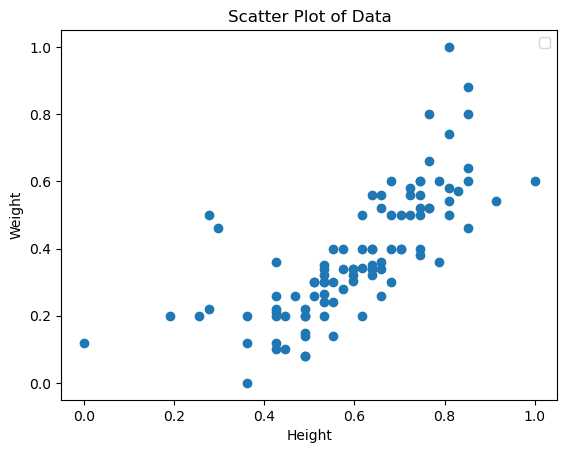

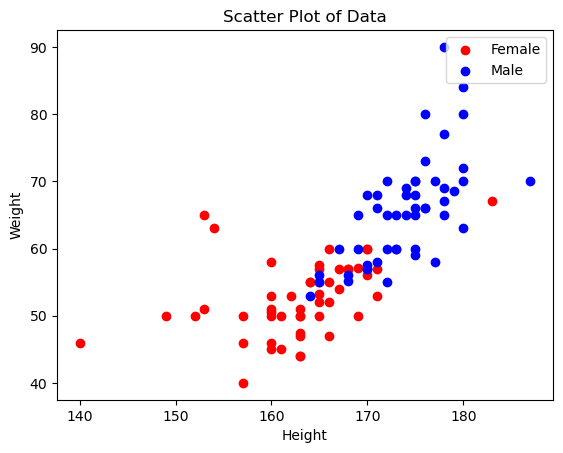

In [19]:
dataset = Dataset(file_paths=['FEMALE.TXT', 'MALE.TXT'])
dataset.display(norm=True)
dataset.display()

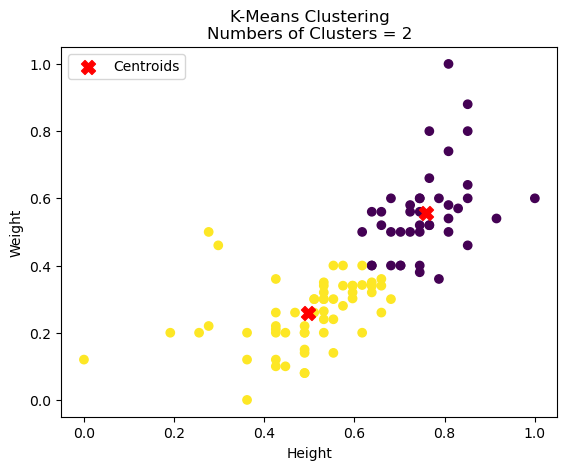

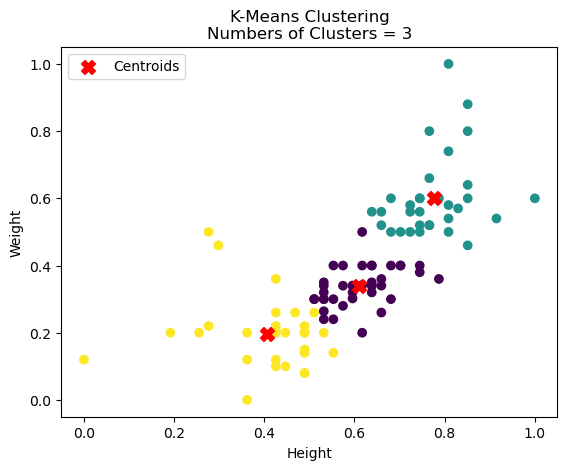

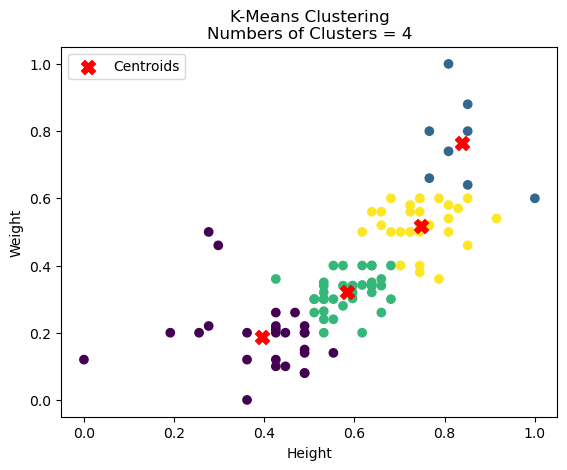

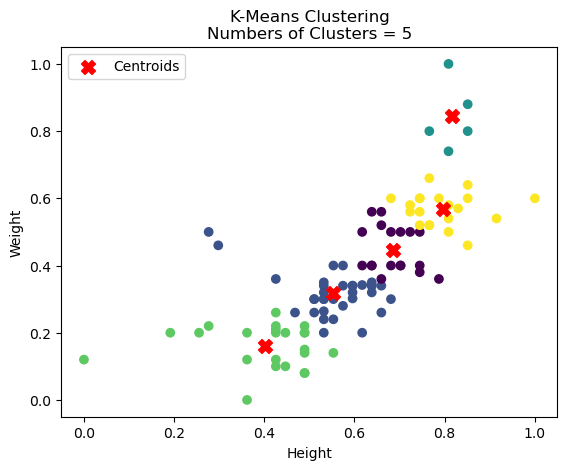

In [4]:
data = dataset.data_norm  # 使用归一化后的数据进行聚类

for k in range(2, 6):
    kmeans = KMeans(k=k, max_iters=100)
    # kmeans.fit(data[:, :-1], initial_centroids=np.array([[0.5, 0.0], [1.0, 1.0]]))
    kmeans.fit(data[:, :-1])
    kmeans.display()


Iteration Num of Cluster = 5: 100%|██████████| 20/20 [00:00<00:00, 71.43it/s]


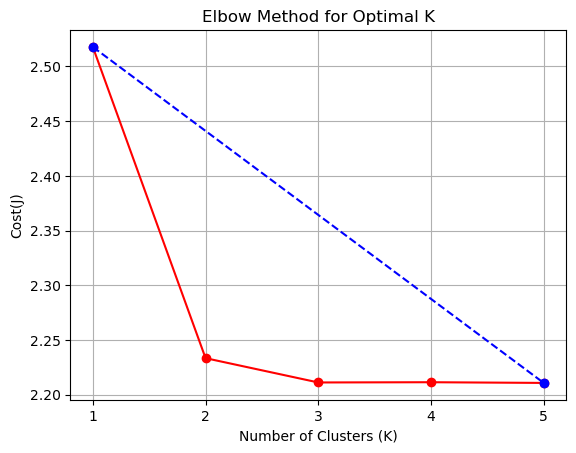

In [18]:
J_li = []
K = range(1, 6)
num_runs = 20
for k in K:
    J_total = 0.0
    for _ in tqdm.tqdm(range(num_runs), f'Iteration Num of Cluster = {k}'):
        kmeans = KMeans(k=k, max_iters=100000)
        kmeans.fit(data[:, :-1])
        J_total = J_total + kmeans.J
    J_li.append(J_total / num_runs)

plt.plot(K, J_li, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost(J)')
plt.title('Elbow Method for Optimal K')
plt.xticks(K)  # 设置X轴刻度为离散的K值
plt.grid(True)

# 连接第一个点和最后一个点
plt.plot([K[0], K[-1]], [J_li[0], J_li[-1]], linestyle='--', marker='o', color='b')

plt.show()

Iteration Num of Cluster = 5: 100%|██████████| 10/10 [00:00<00:00, 23.09it/s]


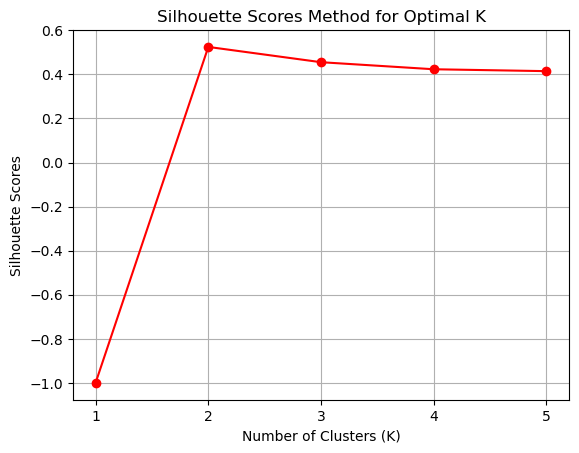

In [24]:
data = dataset.data_norm  # 使用归一化后的数据进行聚类

J_li = []
K = range(1, 6)
num_runs = 10
for k in K:
    J_total = 0.0
    for _ in tqdm.tqdm(range(num_runs), f'Iteration Num of Cluster = {k}'):
        kmeans = KMeans(k=k, max_iters=10000)
        kmeans.fit(data[:, :-1])
        J_total = J_total + kmeans.J1
    J_li.append(J_total / num_runs)

plt.plot(K, J_li, marker='o', linestyle='-', color='r')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Scores')
plt.title('Silhouette Scores Method for Optimal K')
plt.xticks(K)  # 设置X轴刻度为离散的K值
plt.grid(True)
plt.show()